# Signals based on Realized Volatility Forecasting with GARCH and Multivariate LSTM


In [ ]:
!pip install arch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 14.8 MB/s eta 0:00:00


In [ ]:
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 61.1 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from scipy import stats

%matplotlib inline

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import yfinance as yf

from datetime import datetime, timedelta
from sklearn.metrics import mean_squared_error as mse
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [ ]:
# Ref: https://towardsdatascience.com/8-commonly-used-pandas-display-options-you-should-know-a832365efa95
# ADJUST COLUMN WIDTH IN PANDAS TO SHOW ALL TEXT
# (FOR MODEL PERFORMANCE DISPLAY LATER)

pd.set_option('display.max_colwidth', None)

In [ ]:
# PRE-SET PATH TO images FOLDER TO SAVE PLOTS LATER
directory_to_img = os.path.join('..', '..', 'images')

### Load Data from `yfinance`

In [ ]:
# SET SEED FOR REPRODUCIBILITY
seed = 2021

In [ ]:
# SELECT START AND END DATE
start = datetime(2014, 1, 1)
end = datetime(2021, 8, 31)


tckr = 'BTC-USD'

ticker = yf.Ticker(tckr)
df = ticker.history(start=start, 
                    end=end, 
                    interval="1d")

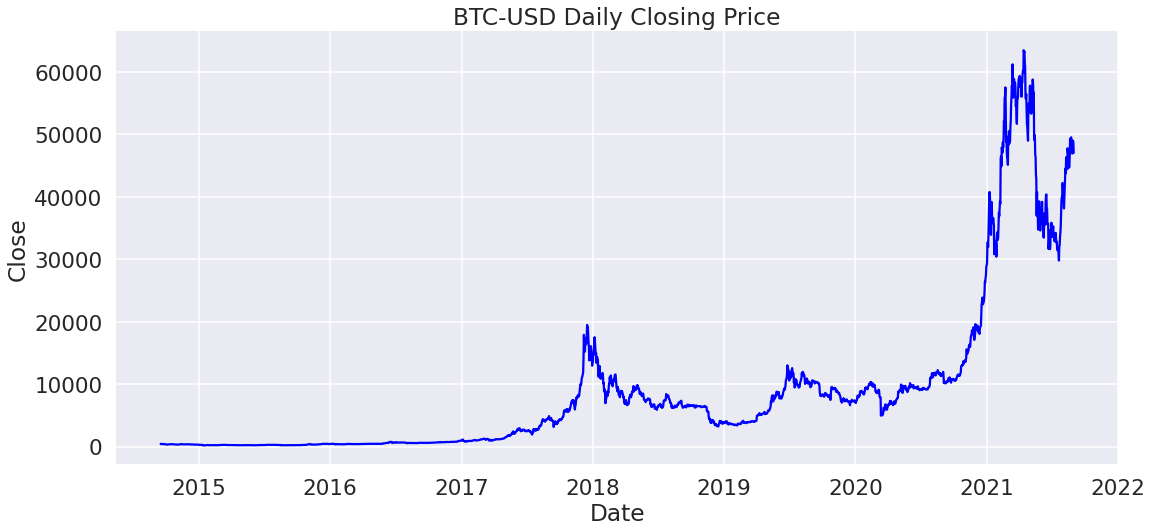

In [ ]:
# CHANGE CONTEXT TO poster TO INCREASE FONT SIZES
sns.set_context("talk", font_scale=1.3)

# PLOT OUT BTC-USE'S CLOSING PRICES SINCE 2014
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(18,8))
    sns.lineplot(x=df.index, y=df.Close, color='blue')
    ax.set_title('BTC-USD Daily Closing Price')    



In [ ]:
# CALCULATE PRICE RETURNS AS DAILY PERCENTAGE CHANGE USING pct_change()
df['returns'] = 100 * df.Close.pct_change().dropna()

В практических целях обычно предпочтительнее использовать логарифмические результаты, особенно в математическом моделировании, поскольку это помогает устранить нестационарные свойства данных временных рядов и делает их более стабильными: 


LOG RETURNS FORMULA:

$r_{t, t+i} = log(P_{t+i} / P_{t})$

There's another advantage to log returns, which is that they're additive across time: $r_{t1, t2} + r_{t2, t3} = r_{t1, t3}$


In [ ]:
# CALCULATE LOG RETURNS BASED ON ABOVE FORMULA
df['log_returns'] = np.log(df.Close/df.Close.shift(1))

In [ ]:
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns
Date,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,NaN,NaN
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,-7.192558,-0.074643
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,-6.984265,-0.072402
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0,3.573492,0.035111
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0,-2.465854,-0.024968


In [ ]:
# DROPPING THE 1ST ROW OF DATA 
# BECAUSE I SHIFTED IT FORWARD TO CALCULATE RETURNS/LOG RETURNS
df.dropna(inplace=True)

In [ ]:
df.returns.describe()

count    2539.000000
mean        0.260028
std         3.914642
min       -37.169539
25%        -1.280782
50%         0.199896
75%         1.825499
max        25.247169
Name: returns, dtype: float64

In [ ]:
df.log_returns.describe()

count    2539.000000
mean        0.001825
std         0.039483
min        -0.464730
25%        -0.012891
50%         0.001997
75%         0.018090
max         0.225119
Name: log_returns, dtype: float64


The standard deviation will be different for log returns computed over longer or shorter intervals. For this specific project, the volatility would be for a certain fixed interval window (`INTERVAL_WINDOW`) is the standard deviation of log returns, or the square root of the sum of squares of log returns:

$\sigma_{interval} = \sqrt{\sum_{t} r_{t-1, t}^2}$

And then to scale the daily volatility by a certain frequency (weekly, monthly, yearly), we can multiply the daily volatility by the square root of that frequency in terms of day divided by the interval minus 1 (`INTERVAL_WINDOW - 1`). For example:

$\sigma_{daily} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{1}{interval-1}}$

$\sigma_{annualized} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{365}{interval-1}}$

$\sigma_{monthly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{30}{interval-1}}$

$\sigma_{weekly} = \sqrt{\sum_{t} r_{t-1, t}^2} * \sqrt{\frac{7}{interval-1}}$


In [ ]:
# CREATE A FUNCTION THAT CALCULATE REALIZED VOLATILITY
# FROM SAILY LOG RETURNS
def realized_volatility_daily(series_log_return):
    """
    Get the daily realized volatility which is calculated as the square root
    of sum of squares of log returns within a specific window interval 
    """
    n = len(series_log_return)
    return np.sqrt(np.sum(series_log_return**2)/(n - 1))

### Interval Window Selection

For this specific project I'll use an **interval window of 30 days** (equivalent to roughly 1 month of trading for cryptocurrencies). The goal here is to **forecast the average realized volatility of the next `n_future` 7 days** using all previous available datapoint with GARCH models (expanding window forecasting), and using a number of immediate past/historical datapoints (`n_past`) with Neural Networks (sliding window forecasting). 


In [ ]:
intervals = [7, 30, 60, 180, 365]
vols_df = {}

# ITERATE OVER intervals LIST
for i in intervals:
    # GET DAILY LOG RETURNS USING THAT INTERVAL
    vols = df.log_returns.rolling(window=i)\
                         .apply(realized_volatility_daily).values

    vols_df[i] = vols

# CONVERT vols_df FROM DICTIONARY TO PANDAS DATAFRAME
vols_df = pd.DataFrame(vols_df, columns=intervals, index=df.index)


Причина, по которой я выбрал 30 дней, заключается в том, что 7 дней кажутся слишком шумными для наблюдения значимых моделей, в то время как более длинные интервалы, по-видимому, значительно сглаживают волатильность и имеют тенденцию возвращаться к среднему значению.

Использование окна интервала в 30 дней также поможет избежать потери слишком большого количества точек данных в начале набора данных.

Модели прогнозирования временных рядов — это модели, способные предсказывать будущие значения на основе ранее наблюдаемых значений. Целевые «будущие» данные в этом случае получаются путем **сдвига текущей волатильности назад** на число лагов n_future.

Например, по отношению к понедельнику прошлой недели понедельник этой недели является «будущим»; поэтому мне просто нужно сдвинуть волатильность на этой неделе назад на 7 дней и использовать ее в качестве желаемого «будущего» результата прошлой недели, который затем я буду использовать для обучения нейронных сетей и оценки производительности модели.

In [ ]:
INTERVAL_WINDOW = 30
n_future = 7

# GET BACKWARD LOOKING REALIZED VOLATILITY
df['vol_current'] = df.log_returns.rolling(window=INTERVAL_WINDOW)\
                                   .apply(realized_volatility_daily)

# GET FORWARD LOOKING REALIZED VOLATILITY 
df['vol_future'] = df.log_returns.shift(-n_future)\
                                 .rolling(window=INTERVAL_WINDOW)\
                                 .apply(realized_volatility_daily)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,returns,log_returns,vol_current,vol_future
count,2539.000000,2539.000000,2539.000000,2539.000000,2.539000e+03,2539.0,2539.0,2539.000000,2539.000000,2510.000000,2503.000000
mean,8681.166269,8929.541857,8411.818657,8699.331872,1.348326e+10,0.0,0.0,0.260028,0.001825,0.036331,0.036333
std,12796.869340,13191.400463,12347.219811,12818.326001,1.996122e+10,0.0,0.0,3.914642,0.039483,0.017227,0.017251
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,0.0,0.0,-37.169539,-0.464730,0.007228,0.007228
25%,574.092499,578.319000,568.903992,574.212494,7.275385e+07,0.0,0.0,-1.280782,-0.012891,0.024471,0.024461
50%,5204.105469,5319.986328,5055.194824,5210.515625,4.333440e+09,0.0,0.0,0.199896,0.001997,0.034003,0.033911
75%,9511.579102,9682.253906,9302.726074,9514.672852,2.120531e+10,0.0,0.0,1.825499,0.018090,0.046009,0.046032
max,63523.753906,64863.097656,62208.964844,63503.457031,3.509679e+11,0.0,0.0,25.247169,0.225119,0.103878,0.103878


The 2 columns `Dividends` and `Stock Splits` don't store any information, all rows are `0.0`, so I'll remove them.

In [ ]:
df = df.drop(['Dividends', 'Stock Splits'], axis=1)

In [ ]:
df.describe()

,Open,High,Low,Close,Volume,returns,log_returns,vol_current,vol_future
count,2539.000000,2539.000000,2539.000000,2539.000000,2.539000e+03,2539.000000,2539.000000,2510.000000,2503.000000
mean,8681.166269,8929.541857,8411.818657,8699.331872,1.348326e+10,0.260028,0.001825,0.036331,0.036333
std,12796.869340,13191.400463,12347.219811,12818.326001,1.996122e+10,3.914642,0.039483,0.017227,0.017251
min,176.897003,211.731003,171.509995,178.102997,5.914570e+06,-37.169539,-0.464730,0.007228,0.007228
25%,574.092499,578.319000,568.903992,574.212494,7.275385e+07,-1.280782,-0.012891,0.024471,0.024461
50%,5204.105469,5319.986328,5055.194824,5210.515625,4.333440e+09,0.199896,0.001997,0.034003,0.033911
75%,9511.579102,9682.253906,9302.726074,9514.672852,2.120531e+10,1.825499,0.018090,0.046009,0.046032
max,63523.753906,64863.097656,62208.964844,63503.457031,3.509679e+11,25.247169,0.225119,0.103878,0.103878


Since I am currently using an `INTERVAL_WINDOW` of 30 and a horizon `n_future` of  7, the volatilty of first 30 values as well as the last 7 values of the dataframe would be `NaN`, and therefore need to be dropped from the dataset.

In [ ]:
# DROPPING ALL NaN VALUES
df.dropna(inplace=True)

In [ ]:
df.vol_current.sort_values(ascending=False)[:50]

### **Daily Volatility Grouped by Year**

In [ ]:
# GROUP vol_current BY YEAR AND TAKE THE MEAN
data = df.groupby(by=[df.index.year]).vol_current.mean()

# SELECT PALETTE
pal = sns.color_palette("GnBu", len(data))

# SORT MONTH BY AVERAGE vol_current
rank = data.argsort().argsort()


Cryptocurrencies have gone through some huge structural changes in the last few years that would've affected volatility directly, such as:
- Crypto Options became available on Deribit in 2016
- Bitcoin Futures was offered on CME in 2017
- and then CME Bitcoin Options in 2020

These events have allowed people to trade crypto volatility more efficiently, and therefore data pre-2016 are likely structurally different, and probably followed different patterns compared to data after 2016.

We can these big events being reflected in the plot above - Bitcoin's first record peak in 2017 (around USD 19,800 towards the end of December). And the outliers in 2020 corresponded with its over 200% surge in 2020 (Bitcoin started at USD 7,200 at the beginning of 2020). It reached USD 20,000 on most exchanges on 12/15/2020, and then proceeded to hit USD 30,000 just 17 days later, which is no small feat. To put things in perspective, it took the Dow Jones close to 3 years to make the same move. And then, on 01/07/2021 it broke USD 40,000. As of the time this report is written, BTC-USD is traded at high USD 49,700.

It can be observed that 2021's daily volatiliy overall has also been on the higher side. 

### **Daily Volatility Distribution**

The distribution of daily realized volatility is lightly right skewed, with a small number of larger values spreaded thinly on the right.

A skewed right distribution would have smaller median compared to mean, and mode smaller than median (mode < median < mean).

### **Returns/Log Returns Stationarity Checking**



In [ ]:
from statsmodels.tsa.stattools import adfuller

In [ ]:
# LOG RETURNS
adfuller_results = adfuller(df.log_returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.07120404453572
p-value: 8.719632644592595e-28
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


In [ ]:
# RETURNS
adfuller_results = adfuller(df.returns.dropna())

print(f'ADF Statistic: {adfuller_results[0]}')
print(f'p-value: {adfuller_results[1]}')
print('Critical Values:')
for key, value in adfuller_results[4].items():
    print(f'{key}: {value:.4f}')

ADF Statistic: -15.023108289248311
p-value: 1.0155301109877661e-27
Critical Values:
1%: -3.4330
5%: -2.8627
10%: -2.5674


Using a significant level alpha of 0.05, `p-value` for both Returns and Log Returns are significantly smaller than alpha, which means there's enough evidence to reject the Null Hypothesis. 

--> Returns and Log returns are both not dependent on time/trend

## **Train-Validation-Test Splits**

There're a total of 2500 usable datapoints in this dataset which covers a period of almost 7 years from October 2014 until today (end of August 2021). Since cryptocurrencies are not traded on a regulated exchange, the Bitcoin market is open 24/7, 1 year covers a whole 365 trading days instead of 252 days a year like with other stocks and commodities.

I would split the dataset into 3 parts as follows:
- the most recent 30 usable datapoints would be used for **Final Model Testing - approx. 1.2%**
- 1 full year (365 days) for **Validation and Model Tuning during training - approx. 14.7%**
- and the remaining for **Training - approx. 84.1%**

In [ ]:
# PRE-DETERMINE DESIRED TEST & VALIDATION SIZES
test_size = 30
val_size = 365

# CONVERT TO INDICES
split_time_1 = len(df) - (val_size + test_size)
split_time_2 = len(df) - test_size

# GET CORRESPONDING DATETIME INDICES FOR EACH SET
train_idx = df.index[:split_time_1]
val_idx = df.index[split_time_1:split_time_2]
test_idx = df.index[split_time_2:]

In [ ]:
print(f'TRAINING \tFrom: {train_idx[0]} \tto: {train_idx[-1]} \t{len(train_idx)} days')
print(f'VALIDATION \tFrom: {val_idx[0]} \tto: {val_idx[-1]} \t{len(val_idx)} days')
print(f'TEST \t\tFrom: {test_idx[0]} \tto: {test_idx[-1]} \t{len(test_idx)} days')

TRAINING 	From: 2014-10-17 00:00:00+00:00 	to: 2020-07-24 00:00:00+00:00 	2108 days
VALIDATION 	From: 2020-07-25 00:00:00+00:00 	to: 2021-07-24 00:00:00+00:00 	365 days
TEST 		From: 2021-07-25 00:00:00+00:00 	to: 2021-08-23 00:00:00+00:00 	30 days


The target here would be `vol_future` which represents the daily realized volatility of the next `n_future` days from today (average daily volatility from `t + n_future - INTERVAL_WINDOW` to time step `t + n_future`). 

For example, using an `n_future` value of 7 and an `INTERVAL_WINDOW` of 30, the value that I want to predict at time step `t` would be the average daily realized volatility from time step `t-22` to time step `t+7`.

In [ ]:
# SPLIT FORWARD VOLATILITY INTO 3 PARTS 
# (this would be the target)
y_train = df.vol_future[train_idx]
y_val = df.vol_future[val_idx]
y_test = df.vol_future[test_idx]

In [ ]:
# SPLIT CURRENT DAILY REALIZED VOLATILITY INTO 3 PARTS 
# (this would be the input for baseline, random walk, and NN models)
x_train = df.vol_current[train_idx]
x_val = df.vol_current[val_idx]
x_test = df.vol_current[test_idx]

In [ ]:
# SPLIT RETURNS INTO 3 PARTS
# (this would be the input for GARCH models)
r_train = df.returns[train_idx]
r_val = df.returns[val_idx]
r_test = df.returns[test_idx]

In [ ]:
# SPLIT LOG RETURNS INTO 3 PARTS
# (mostly for visualization)
lr_train = df.log_returns[train_idx]
lr_val = df.log_returns[val_idx]
lr_test = df.log_returns[test_idx]

In [ ]:
y_train.describe()

count    2108.000000
mean        0.035915
std         0.018005
min         0.007228
25%         0.023500
50%         0.033271
75%         0.045736
max         0.103878
Name: vol_future, dtype: float64

In [ ]:
x_train.describe()

count    2108.000000
mean        0.035968
std         0.017978
min         0.007228
25%         0.023549
50%         0.033433
75%         0.045736
max         0.103878
Name: vol_current, dtype: float64

## **Подготовка данных**

### 1. Feature Normalization

As I am going to build various types of models based on different algorithms using different types of inputs, it would be better to normalize the volatilities to standardize the predictions generated by different models. After experimenting with different Scalers, I decided to use `MinMaxScaler` as it yielded best results overall.

In [ ]:
def transform_volatility_to_scaler(scaler, tf_series):
    '''
    Transform a series to a fitted scaler
    '''
    idx = tf_series.index
    output = pd.Series(scaler.transform(tf_series.values.reshape(-1,1))[:,0],
                       index=idx)
    return output

In [ ]:
# INITIATE SCALER
scaler_vol = MinMaxScaler()

# FIT SCALER TO CURRENT VOLATILITY IN TRAINING SET
scaler_vol = scaler_vol.fit(x_train.values.reshape(-1,1))

In [ ]:
# TRANSFORM TRAINING CURRENT & FUTURE VOLATILITIES 
x_train_scaled = transform_volatility_to_scaler(scaler_vol, x_train)
y_train_scaled = transform_volatility_to_scaler(scaler_vol, y_train)

# TRANSFORMING VALIDATION CURRENT & FUTURE VOLATILITIES
x_val_scaled = transform_volatility_to_scaler(scaler_vol, x_val)
y_val_scaled = transform_volatility_to_scaler(scaler_vol, y_val)

# TRANSFORMING TEST CURRENT & FUTURE VOLATILITIES
x_test_scaled = transform_volatility_to_scaler(scaler_vol, x_test)
y_test_scaled = transform_volatility_to_scaler(scaler_vol, y_test)

In [ ]:
x_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.039872
2014-10-18 00:00:00+00:00    0.037566
2014-10-19 00:00:00+00:00    0.035089
2014-10-20 00:00:00+00:00    0.034629
2014-10-21 00:00:00+00:00    0.034362
2014-10-22 00:00:00+00:00    0.034364
2014-10-23 00:00:00+00:00    0.033347
2014-10-24 00:00:00+00:00    0.032900
2014-10-25 00:00:00+00:00    0.033009
2014-10-26 00:00:00+00:00    0.033083
Name: vol_current, dtype: float64

In [ ]:
y_train.head(10)

Date
2014-10-17 00:00:00+00:00    0.032900
2014-10-18 00:00:00+00:00    0.033009
2014-10-19 00:00:00+00:00    0.033083
2014-10-20 00:00:00+00:00    0.033017
2014-10-21 00:00:00+00:00    0.031334
2014-10-22 00:00:00+00:00    0.033474
2014-10-23 00:00:00+00:00    0.033426
2014-10-24 00:00:00+00:00    0.033602
2014-10-25 00:00:00+00:00    0.034075
2014-10-26 00:00:00+00:00    0.033154
Name: vol_future, dtype: float64

In [ ]:
x_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.337754
2014-10-18 00:00:00+00:00    0.313894
2014-10-19 00:00:00+00:00    0.288269
2014-10-20 00:00:00+00:00    0.283501
2014-10-21 00:00:00+00:00    0.280738
2014-10-22 00:00:00+00:00    0.280764
2014-10-23 00:00:00+00:00    0.270238
2014-10-24 00:00:00+00:00    0.265613
2014-10-25 00:00:00+00:00    0.266743
2014-10-26 00:00:00+00:00    0.267507
dtype: float64

In [ ]:
y_train_scaled.head(10)

Date
2014-10-17 00:00:00+00:00    0.265613
2014-10-18 00:00:00+00:00    0.266743
2014-10-19 00:00:00+00:00    0.267507
2014-10-20 00:00:00+00:00    0.266830
2014-10-21 00:00:00+00:00    0.249415
2014-10-22 00:00:00+00:00    0.271550
2014-10-23 00:00:00+00:00    0.271058
2014-10-24 00:00:00+00:00    0.272883
2014-10-25 00:00:00+00:00    0.277768
2014-10-26 00:00:00+00:00    0.268242
dtype: float64

### 2. Train-Validation-Test Visualization

One of the most obvious difference between the 2 plots is the y-axis. After scaling, volatilities fall in the range of [0,1] instead of [0, 0.12] as before.

# Моделирование



## 1. Метрики Эффективности


In [ ]:
# DEFINE ROOT MEAN SQUARED PERCENTAGE ERROR FUNCTION
def RMSPE(y_true, y_pred):
    """
    Compute Root Mean Squared Percentage Error between 2 arrays
    """
    output = np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))
    return output

In [ ]:
# DEFINE ROOT MEAN SQUARED ERROR FUNCTION
def RMSE(y_true, y_pred):
    """
    Compute Root Mean Squared Error between 2 arrays
    """
    output = np.sqrt(mse(y_true, y_pred))
    return output

In [ ]:
# INITIATE A DATAFRAME FOR MODEL PERFORMANCE TRACKING & COMPARISON 
perf_df = pd.DataFrame(columns=['Model', 'Validation RMSPE', 'Validation RMSE'])

In [ ]:
# A FUNCTION THAT LOGS MODEL NAME, RMSE AND RMPSE INTO perf_df
# FOR EASY COMPARISON LATER
def log_perf(y_true, y_pred, model_name):
    perf_df.loc[len(perf_df.index)] = [model_name, 
                                       RMSPE(y_true, y_pred), 
                                       RMSE(y_true, y_pred)]
    return perf_df

## 2. Базовая модель

### 2.1. Базовый уровень

One of the essential characteristics of Volatility is it's **mean-revert** over the long term. Therfore my first baseline model his would be a very simple one that only outputs the average current realized volatility of the whole training set as predictions everything.

In [ ]:
# CALCULATE THE MEAN OF SCALED TRAINING DATA
mean_train_vol = x_train_scaled.mean()
mean_train_vol

0.2973556584762412

In [ ]:
# CREATE SERIES OF PREDICTIONS FOR BASELINE MODEL ON VALIDATION SET
baseline_preds = np.ones(len(val_idx)) * mean_train_vol
baseline_preds = pd.Series(baseline_preds, index=lr_val.index)

In [ ]:
log_perf(y_val_scaled, baseline_preds, 'Mean Baseline')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522


### 2.2. Random Walk Naive Forecasting


In [ ]:
# USING THE PREVIOUS n_future DAY'S VOLATILITY
random_walk_preds = x_val_scaled

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, random_walk_preds, 
         'Random Walk Naive Forecasting')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841


So the both error mertrics have gone down by a decent amount. Naive forecasting in time series is sometimes surprisingly difficult to outperform.

## 3. GARCH Models


### 3.1. Basic GARCH

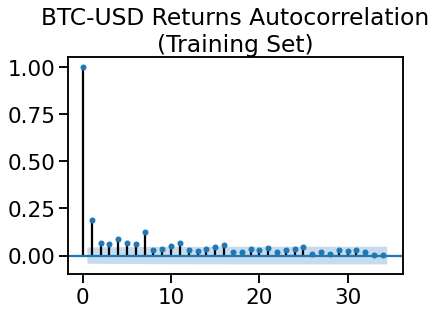

In [ ]:
# VISUALIZE AUTOCORRELATION OF SQUARED RETURNS
plot_acf(r_train**2, 
          title=f'{tckr.upper()} Returns Autocorrelation\n(Training Set)');

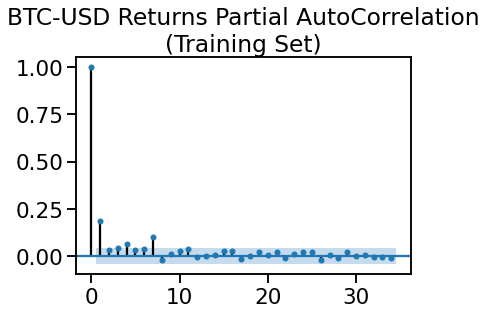

In [ ]:
# VISUALIZE PARTIAL AUTOCORRELATION OF SQUARED RETURNS
plot_pacf(r_train**2, 
          title=f'{tckr.upper()} Returns Partial AutoCorrelation\n(Training Set)');

Графики автокорреляции, по-видимому, указывают на то, что существенная корреляция существует только до 7-го лага, а последующие не кажутся слишком значительными.


In [ ]:
from arch import arch_model

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gm_1 = arch_model(r_train, p=7, q=7)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5612.30
Distribution:                  Normal   AIC:                           11256.6
Method:            Maximum Likelihood   BIC:                           11347.1
                                        No. Observations:                 2108
Date:                Wed, Jan 04 2023   Df Residuals:                     2107
Time:                        19:48:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1787  7.549e-02      2.367  1.792e-02 [3.074e-

Using a significance level of 0.05, none of the coefficients seems to be statistically significant (because their p-values `P > |t|` are all greater than 0.05). Therefore, I'll reduce the values of `p` and `q` to 1 to see if that helps.

In [ ]:
gm_1 = arch_model(r_train, vol='GARCH', p=1, q=1)
result_1 = gm_1.fit(disp='off')
print()
print(result_1.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -5628.11
Distribution:                  Normal   AIC:                           11264.2
Method:            Maximum Likelihood   BIC:                           11286.8
                                        No. Observations:                 2108
Date:                Wed, Jan 04 2023   Df Residuals:                     2107
Time:                        19:48:14   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1993  6.626e-02      3.007  2.636e-03 [6.939e-

Все коэффициенты теперь выглядят статистически значимыми.

In [ ]:
def scale_tf_cond_vol(model_result):
    '''
    Scale & Transform Conditional Volatility 
    Estimated by GARCH Models
    '''
    # OBTAIN ESTIMATED CONDITIONAL VOLATILITY FROM MODEL RESULT
    cond_vol = model_result.conditional_volatility

    # INITIATE SCALER
    scaler = MinMaxScaler()

    # FIT SCALER TO MODEL'S ESTIMATED CONDITIONAL VOLATILITY
    scaler = scaler.fit(cond_vol.values.reshape(-1,1))

    scaled_cond_vol = transform_volatility_to_scaler(scaler, cond_vol)
    return scaler, scaled_cond_vol

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_garch, scaled_cond_vol = scale_tf_cond_vol(result_1)

In [ ]:
# VISUALIZE MODEL'S ESTIMATED CONDITIONAL VOLATILITY 
# WITH SCALED vol_current CALCULATED ABOVE
def viz_cond_vol(cond_vol_series, model_name):
    with sns.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(18,7))

        ax.plot(x_train_scaled, color='blue', lw=2,
                label=f'Scaled {INTERVAL_WINDOW}-Day Interval Daily Realized Volatility')
        ax.plot(cond_vol_series, color='orange', lw=2,
                label=f'Scaled {model_name} Estimated Conditional Volatility')
        ax.set_title('Training Set')
        plt.legend()
        plt.show();

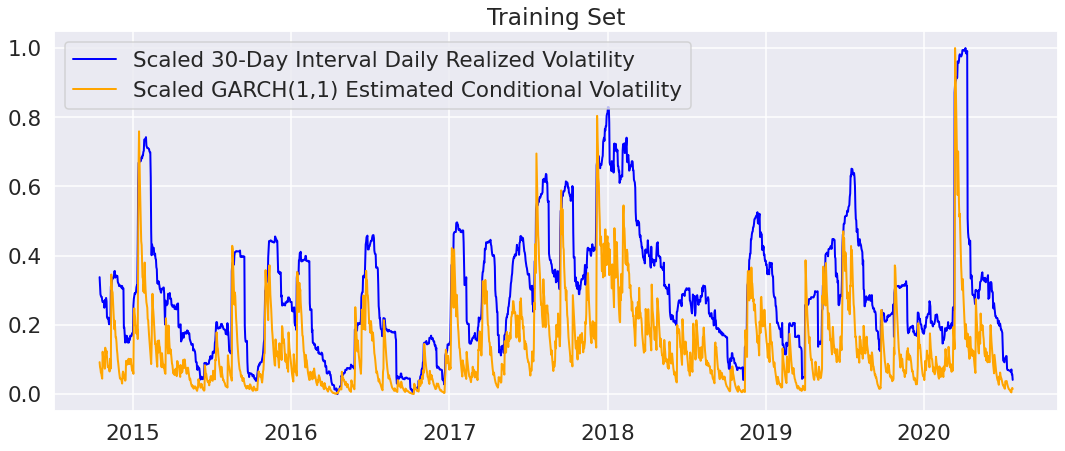

In [ ]:
viz_cond_vol(scaled_cond_vol, 'GARCH(1,1)')

#### 3.1.1. Analytical-based Forecasting

(Source: https://arch.readthedocs.io/en/latest/univariate/univariate_volatility_forecasting.html)

I am implementing rolling one-step forecasting here by refitting the model to ALL the datapoints available up to a certain time step before generating prediction for the next `n_future` days. For example, to make prediction on `vol_future` at time step `t`, I would fit the model to all the `returns` available up to time step `t` and then obtain the average forecasted volatility for a horizon of `n_future = 7`.

The volatility forecasts from the GARCH models using percent returns as input are on a totally different scale compared to the volatilities calculated from log returns. Therefore I am going to normalize the forecasted volatility based on the model's `conditional_volatility` output from the training data, and only comparing the scaled versions of volatilities on the Validation set.

In [ ]:
# ONE STEP EXPANDING WINDOW FORECAST
# INITIALIZING rolling_forecast
rolling_forecasts = []
idx = df.index

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx]
    
    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, vol='GARCH', p=1, q=1,
                       dist='normal')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    # GET THE SQRT OF AVERAGE n_future DAYS VARIANCE
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gm_1_preds = pd.Series(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gm_1_preds_scaled = transform_volatility_to_scaler(scaler_garch, gm_1_preds)

So 7-day horizon forecasting into the future is still lagging behind compared to target values. Similar to the training volatilities comparison above, GARCH's forecasted volatility appears to be lower side (after normalization).

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gm_1_preds_scaled, 
         'GARCH(1,1), Constant Mean, Normal Dist')

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841
2,"GARCH(1,1), Constant Mean, Normal Dist",0.527402,0.184894


Next, I would inspect the estimated residuals from this first GARCH model.

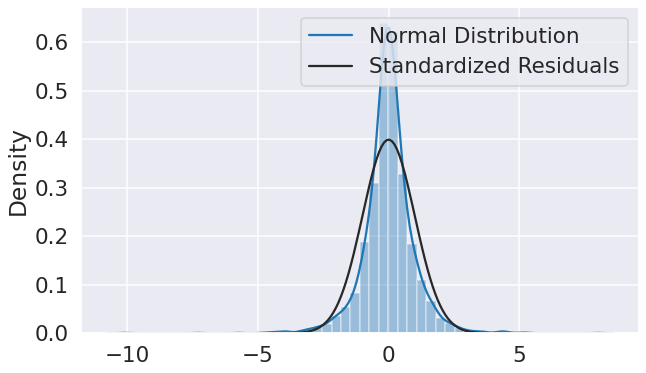

In [ ]:
# INSPECTING THE RESIDUALS
gm_resid = result_1.resid
gm_std = result_1.conditional_volatility

# STANDARDIZING RESIDUALS
gm_std_resid = gm_resid / gm_std

# VISUALIZING STANDARDIZED RESIDUALS VS. A NORMAL DISTRIBUTION
with sns.axes_style("darkgrid"):
    plt.figure(figsize=(10,6))
    sns.distplot(gm_std_resid, norm_hist=True, fit=stats.norm, bins=50)
    plt.legend(('Normal Distribution', 'Standardized Residuals'))
    plt.show();

(Reference: https://goldinlocks.github.io/ARCH_GARCH-Volatility-Forecasting/)

By default, basic GARCH is based on some assumptions that the residuals and the mean return are both normally distributed. However, more often than not, financial time series data does not follow a normal distribution, and it's more likely to observe extreme positive and negative values that are far away from the mean. 

Fortunately, there're certain parameters that can be specified in the `arch_model` library to make it more representative of real financial data:
- `'dist'` can be set to `t` for Student's T or `skewt` for skewed Student's T distribution (Student's T distribution is also symmetric and bell-shaped like normal distribution; however it has higher peak and fatter tails allowing more values lying further away from the mean).

Looking at the plot above of the standardized residuals, I think I can try skewed Student's T for the next fit.



### 3.2. GARCH Model with Asymmetric Shocks Responses

The basic GARCH model assumes positive and negative news have similar impact on volatility. However, in reality the market tends to "*take the stairs up and the elevator down*". In other words, the impact is usually asymmetric, and negative impacts tends to affect the volatility more than positive ones.

There's another member in the GARCH family that accounts for assymmetry of shocks reponses called **GJR-GARCH** (short for **Glosten-Jagannathan-Runkle GARCH**).

Additional inputs can be used to construct other models. In this case, by setting `o` to 1, which means the model would include one lag of an asymmetric shock which transforms a GARCH model into a GJR-GARCH model with variance dynamics.

In [ ]:
# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

gjr_gm = arch_model(r_train, p=1, q=1, o=1, 
                    vol='GARCH', dist='skewt')
result_2 = gjr_gm.fit(disp='off')
print(result_2.summary())

                         Constant Mean - GJR-GARCH Model Results                         
Dep. Variable:                           returns   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5291.01
Distribution:      Standardized Skew Student's t   AIC:                           10596.0
Method:                       Maximum Likelihood   BIC:                           10635.6
                                                   No. Observations:                 2108
Date:                           Wed, Jan 04 2023   Df Residuals:                     2107
Time:                                   19:48:41   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
----------------------------------------

Log-likelihood has increased quite a bit. Let's see how the conditional volatility looks.

In [ ]:
# GET VOLATILITY SCALER & SCALED CONDITIONAL VOLATILITY FROM MODEL RESULT
scaler_gjr, scaled_gjr_cond_vol = scale_tf_cond_vol(result_2)

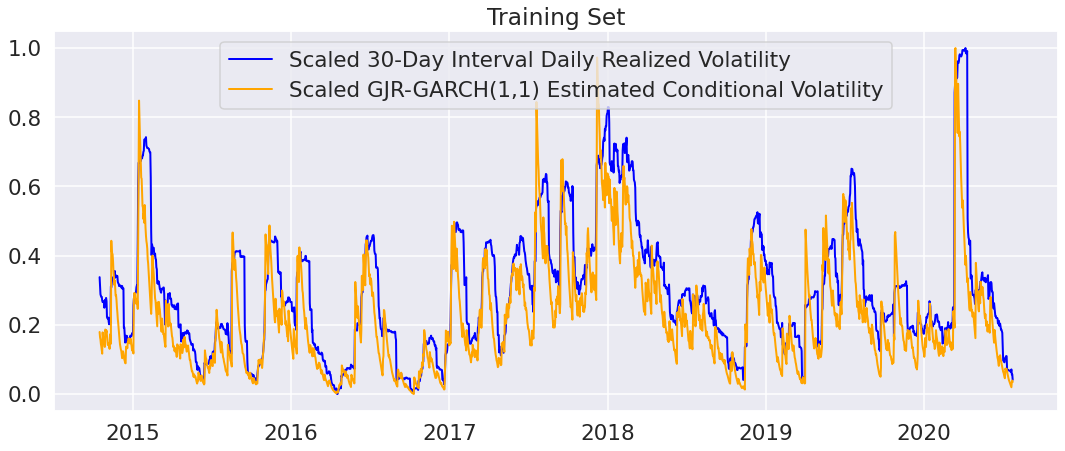

In [ ]:
viz_cond_vol(scaled_gjr_cond_vol, 'GJR-GARCH(1,1)')

In [ ]:
# ROLLING WINDOW FORECAST
# INITIALIZING rolling_forecasts VALUES LIST
rolling_forecasts = []

# ITERATE OVER EACH TIME STEP IN THE VALIDATION SET
for i in range(len(val_idx)):
    # GET THE DATA AT ALL PREVIOUS TIME STEPS
    idx = val_idx[i]
    train = df.returns[:idx].dropna()

    # TRAIN MODEL USING ALL PREVIOUS TIME STEPS' DATA
    model = arch_model(train, p=1, q=1, o=1, 
                       vol='GARCH', dist='skewt')
    model_fit = model.fit(disp='off')

    # MAKE PREDICTION n_future DAYS OUT
    vaR = model_fit.forecast(horizon=n_future, 
                             reindex=False).variance.values
    pred = np.sqrt(np.mean(vaR))

    # APPEND TO rolling_forecasts LIST
    rolling_forecasts.append(pred)

gjr_1_preds = pd.DataFrame(rolling_forecasts, index=val_idx)

In [ ]:
# TRANSFORM PREDICTIONS USING FITTED SCALER
gjr_1_preds_scaled = transform_volatility_to_scaler(scaler_gjr, gjr_1_preds)

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, gjr_1_preds_scaled, 
         "Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841
2,"GARCH(1,1), Constant Mean, Normal Dist",0.527402,0.184894
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.270103,0.088866


Compared to GARCH(1,1) with Normal Distribution setting, GJR-GARCH with Skewed Student's T forecasts have moved up quite a bit and shortened the gap between target values and model's predictions. This is also reflected in an improvement in both Validation RMSPE and RMSE.

Unfortunately I still haven't been able to get close to Naive Forecasting.

## 4. Нейронные сети

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import backend as K
from decimal import Decimal

For Neural Networks, instead of feeding all available datapoints into the network at once, I will use a **sliding lookback window** to extract uniform input arrays and target outputs. I will just using a stride value of 1 to make sure I get all the inputs and output combinations available since 2500 datapoints is not really a whole lot to spare. 

This is a demonstration of sliding window:


In [ ]:
# CONVERT AN SERIES TO MATRIX DATASET
def windowed_dataset(x_series, y_series, lookback_window):
    dataX, dataY = [], []
    for i in range((lookback_window-1), len(x_series)):
        start_idx = x_series.index[i-lookback_window+1]
        end_idx = x_series.index[i]
        a = x_series[start_idx:end_idx].values
        dataX.append(a)
        dataY.append(y_series[end_idx])

    return np.array(dataX), np.array(dataY)

In [ ]:
def rmspe(y_true, y_pred):
    '''
    Compute Root Mean Square Percentage Error between two arrays
    that can be used as metrics for NN during training
    '''
    loss = K.sqrt(K.mean(K.square((y_true - y_pred) / y_true)))

    return loss

To generate predictions using Neural Networks, I will use the same sliding window concept again:

This means that to generate future predictions for a time step `t`, I will need to traverse back in time and collect the last `n_past` datapoints (from time step `t - n_past + 1` to `t` inclusively). That's why the shape of the inputs into these Neural Networks need to be **`[batch_size, n_past, 1]`**.

In [ ]:
def forecast(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(df.vol_current[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

In [ ]:
def scale(scaler, y_series):
    scaled = pd.Series(scaler.transform(y_series.values.reshape(-1,1))[:, 0],
                       index=y_series.index)
    return scaled

In [ ]:
def viz_train_val_metrics(model_hist):
    with sns.axes_style("white"):
        fig, ax = plt.subplots(figsize=(15,6))

        # PLOT MSE - LEFT Y-AXIS
        # TRAINING
        ln11 = ax.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['loss'], color='lightblue',
                    label='Training MSE', lw=2)
        # VALIDATION
        ln12 = ax.plot(range(len(model_hist.history['loss'])),
                    model_hist.history['val_loss'], color='darkblue',
                    label='Validation MSE', lw=2)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('MSE')

        # PLOT RMSE - RIGHT Y-AXIS
        ax2 = ax.twinx()
        ln21 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['rmspe'], color='pink', lw=2,
                    label='Training RMSPE')
        ln22 = ax2.plot(range(len(model_hist.history['loss'])), 
                    model_hist.history['val_rmspe'], color='red', lw=2,
                    label='Validation RMSPE')
        ax2.set_ylabel('RMSPE')

        # COMBINING LALBELS FOR 4 LINES INTO 1 LEGEND
        lns = ln11 + ln12 + ln21 + ln22
        labs = [l.get_label() for l in lns]
        ax.legend(lns, labs, loc='best')

        ax.set_title('Training vs. Validation Learning Curves')
        plt.show();

### 4.1. Neural Network Baseline Metrics - Fully Connected Network**

This is essentially Linear Regression.

(Training directly using scaled volatility produces `inf` RMSPE, so I'll stick with the original volatility, and scale the forecasts later).

I will start with using a lookback window `n_past` of 14, and then gradually adjust that value based on the outcomes of my models.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

snn_1 = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[n_past, 1]),                          
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

snn_1.compile(loss='mse', 
              optimizer='adam', 
              metrics=[rmspe])

print(snn_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 14)                0         
                                                                 
 dense (Dense)               (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# FIT MODEL TO TRAINING DATASET 
snn_1_res = snn_1.fit(mat_X_train, mat_y_train, epochs=100,
                      validation_split=0.2,
                      verbose=0, batch_size=batch_size, 
                      shuffle=True)

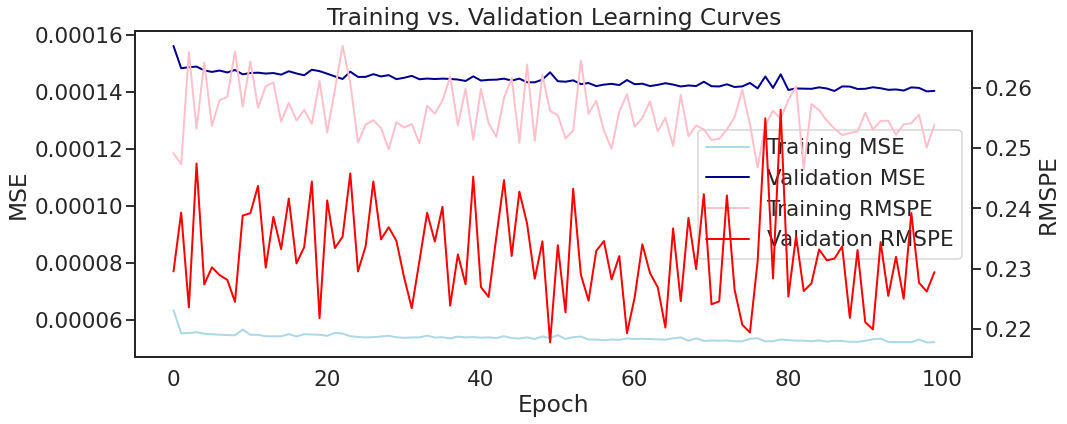

In [ ]:
viz_train_val_metrics(snn_1_res)

In [ ]:
# FORECASTING ON VALIDATION SET
snn_1_preds = forecast(snn_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
snn_1_preds_scaled = scale(scaler_vol, snn_1_preds)

12/12 [==============================] - 0s 1ms/step


The forecast is tracing the current volatility line very closely, but is mostly lagging behind compared to my target values.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, snn_1_preds_scaled,
         f"Simple LR Fully Connected NN, n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841
2,"GARCH(1,1), Constant Mean, Normal Dist",0.527402,0.184894
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.270103,0.088866
4,"Simple LR Fully Connected NN, n_past=14",0.228006,0.049943


A simple Fully Connected NN doesn't perform too bad. Validation RMSPE after 100 epochs of training and barely any tuning is already only a bit higher than best TARCH(1,2) model's RMSPE, and actually lower on RMSE.

### 4.2. Univariate Long Short-Term Memory (LSTM)**

(Reference: Geron (2019)

There's a class of Neural Networks called **Recurrent Neural Networks (RNN)** that can "predict the future". RNN works well with time series data, such as stock prices, and can even process sentences, documents, audio samples as inputs. Another application of RNN is in autonomic driving systems, where they're used to anticipate vehicle trajectories and help avoid accidents.

At each time step `t`, the recurrent neuron receives input $x_{t}$ as well as its own output from the previous time step $y_{t-1}$. Since the output of a Recurrent Neuron is a function of all the inputs from the previous time steps, it has a form of *memory* and able to preserve some information through time.

However, due to some transformations that the data goes through when traversing down RNN, some information is lost at each time step, and for a long sequence, the RNN's state contains virtually no information from the first inputs. 

**Long Short-Term Memory (LSTM)** was proposed in 1997 by Sepp Hochreiter and Jurgen Schmidhuber. The key part of LSTM is that the network can learn what's important and needs to be stored in the long-term state, and what can be ignored. LSTM looks very similar to a regular RNN cell, but its state is split into 2 vectors:
- $h_{t}$ - for short term state
- $c_{t}$ - for long term state

LSTM is a black box, and can be used like a basic Recurrent Neural Network (RNN) cell. However, it tends to perform much better, helps training converge faster, and also detect long-term dependencies in the data.

LSTM uses an **optimized implementation when running on a GPU**, that's why it's highly recommended to run this second part of the notebook on **Google Colab**.


First, I'm going to use the same lookback window `n_past` as the previous Neural Networks (30), and then depending on the result, I'll try to fine tune that value later.

The first LSTM model would be very simple with only 1 hidden LSTM layer of 20 units. I am using the standard `adam` optimizer here, and would later experiment with other optimizers if needed.

In [ ]:
# CLEARING ANY INTERNAL VARIABLES TO PREVENT MODELS
# FROM IMPACTING LATER VERSIONS OF THEMSELVES
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 14
batch_size = 64

mat_X_train, mat_y_train = windowed_dataset(x_train, y_train, n_past)

lstm_1 = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), 
                           input_shape=[None]),                            
    # ADDING 1 LSTM LAYER
    tf.keras.layers.LSTM(20),
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_1.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_1.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, None, 1)           0         
                                                                 
 lstm (LSTM)                 (None, 20)                1760      
                                                                 
 dense (Dense)               (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# FIT TO TRAINING DATA
lstm_1_res = lstm_1.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

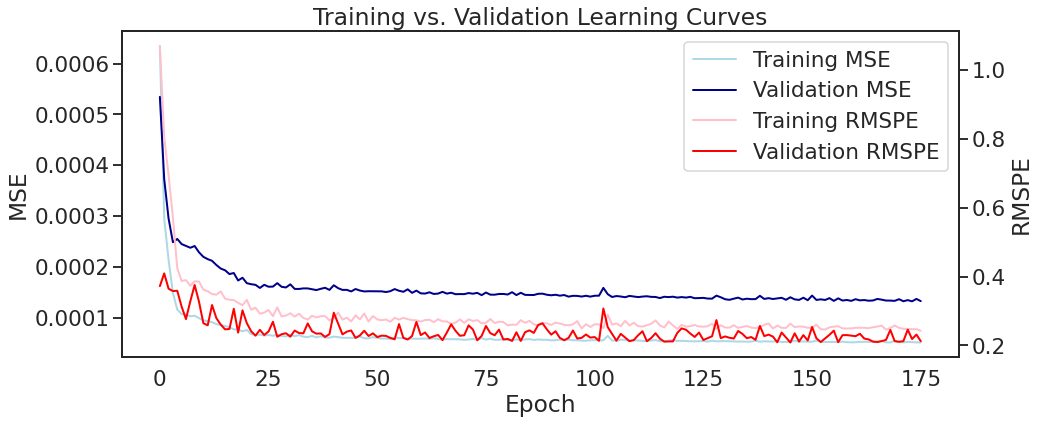

In [ ]:
# VISUALIZE TRAINING VS. VALIDATION LOSS METRICS
viz_train_val_metrics(lstm_1_res)

Validation RMSPE is actually lower than Training RMSPE, but overall all the lines except for Training MSE look quite unstable.

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_1_preds = forecast(lstm_1, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_1_preds_scaled = scale(scaler_vol, lstm_1_preds)

12/12 [==============================] - 0s 3ms/step


Again, predictions traces `vol_current` quite closely, and the prediction line has smoothed out compared to the fully connected NN's predictions (meaning it's less noisy), but it is still also lagging behind compared to desired target.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_1_preds_scaled, 
         f"LSTM 1 layer 20 units, n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841
2,"GARCH(1,1), Constant Mean, Normal Dist",0.527402,0.184894
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.270103,0.088866
4,"Simple LR Fully Connected NN, n_past=14",0.228006,0.049943
5,"LSTM 1 layer 20 units, n_past=14",0.215075,0.053833


Simple 1-layered LSTM is only a tiny bit better than fully connected network on RMSPE, and actually has higher RMSE than the simple LR NN above.

### 4.6. Multivariate LSTM

So far I have only using simple 1-dimensional inputs for all of my models, and for financial data, this is likely insufficient. That could be the reason why most of the above models seems failed to yield better result than Naive Forecasting. It doesn't matter how many neurons or hidden layers are used, or how complex the model's architectures are, inadequate data is most likely not going to produce good results.

For the next section, I'll attempt to create Multivariate Neural Networks to see if additional features could help improve performance.

In [ ]:
df.head()

,Open,High,Low,Close,Volume,returns,log_returns,vol_current,vol_future
Date,,,,,,,,,
2014-10-17 00:00:00+00:00,382.756012,385.477997,375.389008,383.757996,13600700,0.314201,0.003137,0.039872,0.032900
2014-10-18 00:00:00+00:00,383.976013,395.157990,378.971008,391.441986,11416800,2.002301,0.019825,0.037566,0.033009
2014-10-19 00:00:00+00:00,391.253998,393.938995,386.457001,389.545990,5914570,-0.484362,-0.004855,0.035089,0.033083
2014-10-20 00:00:00+00:00,389.230988,390.084015,378.252014,382.845001,16419000,-1.720205,-0.017352,0.034629,0.033017
2014-10-21 00:00:00+00:00,382.420990,392.645996,380.834015,386.475006,14188900,0.948166,0.009437,0.034362,0.031334


In [ ]:
df.info()

In [ ]:
df.describe()

In [ ]:
df['HL_sprd'] = np.log((df.High - df.Low) / df.Close)
df['CO_sprd'] = (df.Close - df.Open) / df.Open
df['Volume'] = np.log(df.Volume)

In [ ]:
df.head()

,Open,High,Low,Close,Volume,returns,log_returns,vol_current,vol_future,HL_sprd,CO_sprd
Date,,,,,,,,,,,
2014-10-17 00:00:00+00:00,382.756012,385.477997,375.389008,383.757996,16.425632,0.314201,0.003137,0.039872,0.032900,-3.638567,0.002618
2014-10-18 00:00:00+00:00,383.976013,395.157990,378.971008,391.441986,16.250597,2.002301,0.019825,0.037566,0.033009,-3.185630,0.019444
2014-10-19 00:00:00+00:00,391.253998,393.938995,386.457001,389.545990,15.592929,-0.484362,-0.004855,0.035089,0.033083,-3.952483,-0.004365
2014-10-20 00:00:00+00:00,389.230988,390.084015,378.252014,382.845001,16.613950,-1.720205,-0.017352,0.034629,0.033017,-3.476822,-0.016407
2014-10-21 00:00:00+00:00,382.420990,392.645996,380.834015,386.475006,16.467971,0.948166,0.009437,0.034362,0.031334,-3.487953,0.010601


In [ ]:
features = ['HL_sprd', 'CO_sprd', 'Volume', 'vol_current']

#### 4.6.2. Input Reshaping

In [ ]:
# SEPARATE INPUT DATAFRAME FROM df
input_df = df[features]

# SEPARATE INPUTS FOR TRAINING SET ONLY
X_train = input_df.loc[train_idx]

In [ ]:
X_train.head()

,HL_sprd,CO_sprd,Volume,vol_current
Date,,,,
2014-10-17 00:00:00+00:00,-3.638567,0.002618,16.425632,0.039872
2014-10-18 00:00:00+00:00,-3.185630,0.019444,16.250597,0.037566
2014-10-19 00:00:00+00:00,-3.952483,-0.004365,15.592929,0.035089
2014-10-20 00:00:00+00:00,-3.476822,-0.016407,16.613950,0.034629
2014-10-21 00:00:00+00:00,-3.487953,0.010601,16.467971,0.034362


In [ ]:
input_df.head()

,HL_sprd,CO_sprd,Volume,vol_current
Date,,,,
2014-10-17 00:00:00+00:00,-3.638567,0.002618,16.425632,0.039872
2014-10-18 00:00:00+00:00,-3.185630,0.019444,16.250597,0.037566
2014-10-19 00:00:00+00:00,-3.952483,-0.004365,15.592929,0.035089
2014-10-20 00:00:00+00:00,-3.476822,-0.016407,16.613950,0.034629
2014-10-21 00:00:00+00:00,-3.487953,0.010601,16.467971,0.034362


In [ ]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2108 entries, 2014-10-17 00:00:00+00:00 to 2020-07-24 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2108 non-null   float64
 1   CO_sprd      2108 non-null   float64
 2   Volume       2108 non-null   float64
 3   vol_current  2108 non-null   float64
dtypes: float64(4)
memory usage: 82.3 KB


In [ ]:
input_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2503 entries, 2014-10-17 00:00:00+00:00 to 2021-08-23 00:00:00+00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   HL_sprd      2503 non-null   float64
 1   CO_sprd      2503 non-null   float64
 2   Volume       2503 non-null   float64
 3   vol_current  2503 non-null   float64
dtypes: float64(4)
memory usage: 162.3 KB


In [ ]:
def forecast_multi(model, range_idx):
    start_idx = range_idx[0] - timedelta(n_past - 1)
    end_idx = range_idx[-1]
    mat_X, _ = windowed_dataset(input_df[start_idx:end_idx], 
                                df.vol_future[range_idx], n_past)
    preds = pd.Series(model.predict(mat_X)[:, 0],
                      index=range_idx)

    return preds

### 4.7. Multivariate 2-Layered Bidirectional LSTM with Dropout

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_5 = tf.keras.models.Sequential([ 
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_5.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_5.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_5.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_5_res = lstm_5.fit(mat_X_train, mat_y_train, 
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2, shuffle=True,
                        verbose=0, batch_size=batch_size, epochs=200)

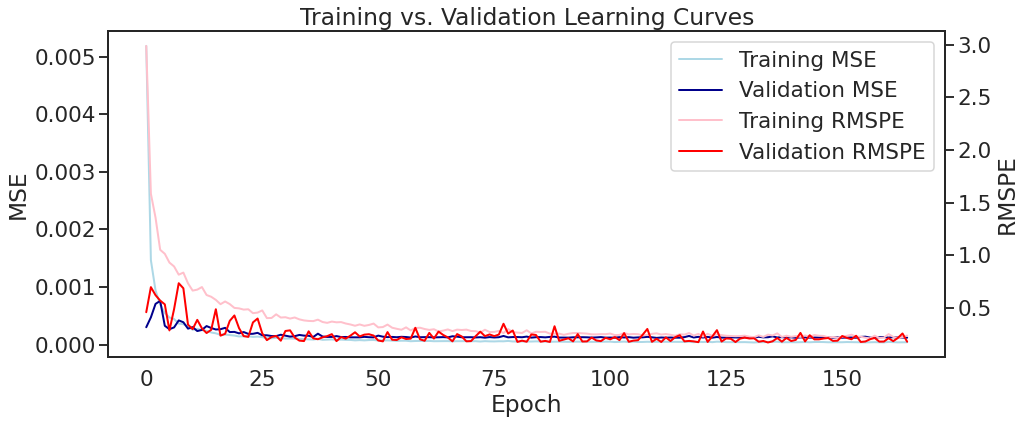

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_5_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_5_preds = forecast_multi(lstm_5, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_5_preds_scaled = scale(scaler_vol, lstm_5_preds)

12/12 [==============================] - 2s 10ms/step


The prediction line has moved horizontally more towards target lines, and has actually traced the desired output very closely between November 2020 to February 2021. This is certainly an improvement compared to all the previous model. It also doesn't look as noisy as some of the other ones.

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_5_preds_scaled,
         f"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841
2,"GARCH(1,1), Constant Mean, Normal Dist",0.527402,0.184894
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.270103,0.088866
4,"Simple LR Fully Connected NN, n_past=14",0.228006,0.049943
5,"LSTM 1 layer 20 units, n_past=14",0.215075,0.053833
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.192874,0.055739
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.213783,0.061715
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",0.521983,0.206906
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.159135,0.043890



This is the first model with a Validation RMSPE sub 0.2, and it's actually almost 5% lower than the best model found above (Univariate LSTM with 2 layers). 

(I have also experimented with adding 1D convolutional layers to this Multivariate LSTM models, which is available in the Exploratory Notebooks folder, but it did not produce better results, so I am going to omit that version here).

### 4.8. Multivariate 3-Layered Bidirectional LSTM

Next, I'm going to add more LSTM layers to see if that helps improve performance.

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_6 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 
    
    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_6.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_6.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_6.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 128)          35328     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 128)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 64)           41216     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 64)            0         
                                                        

In [ ]:
lstm_6_res = lstm_6.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

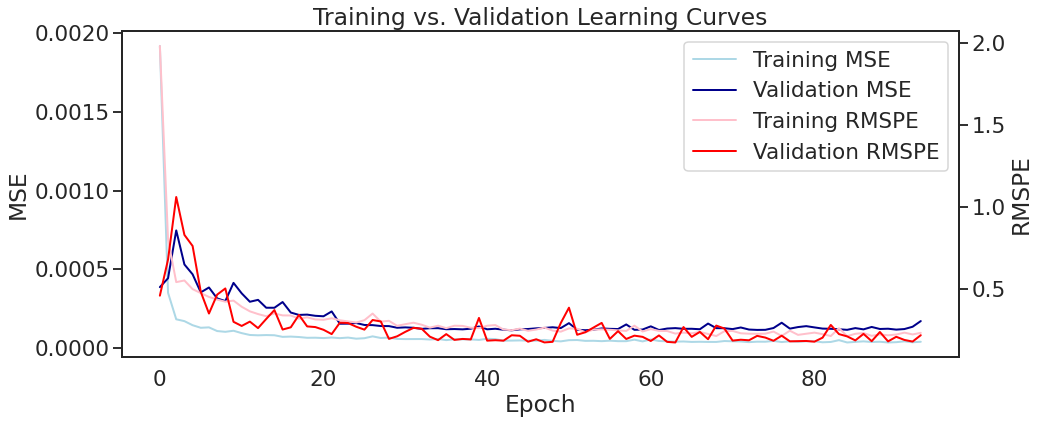

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_6_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_6_preds = forecast_multi(lstm_6, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_6_preds_scaled = scale(scaler_vol, lstm_6_preds)

12/12 [==============================] - 3s 22ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_6_preds_scaled,
         f"Multivariate Bidirect LSTM 3 layers (64/32/16 units), n_past={n_past}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841
2,"GARCH(1,1), Constant Mean, Normal Dist",0.527402,0.184894
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.270103,0.088866
4,"Simple LR Fully Connected NN, n_past=14",0.228006,0.049943
5,"LSTM 1 layer 20 units, n_past=14",0.215075,0.053833
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.192874,0.055739
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.213783,0.061715
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",0.521983,0.206906
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.159135,0.043890


Adding another LSTM layer helped reduce RMSE by a small margin (from 0.046139 to 0.044660), but RMSPE has actually gone up slightly (from 0.156677 to 0.164623).

### 4.8. Multivariate 4-Layered Bidirectional LSTM

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_7 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    # ADDING 4th LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_7.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_7.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_7.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 256)          136192    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 256)           0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 30, 128)          164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_7_res = lstm_7.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

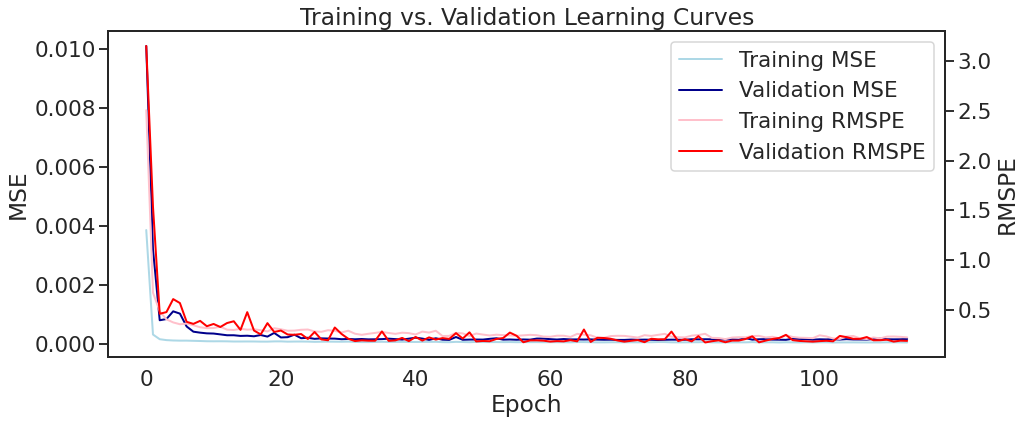

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_7_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_7_preds = forecast_multi(lstm_7, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_7_preds_scaled = scale(scaler_vol, lstm_7_preds)

12/12 [==============================] - 4s 57ms/step


In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_7_preds_scaled, 
         f"Multivariate 4 Bidirect LSTM layers (128/64/32/16 units), n_past={n_past}, batch={batch_size}")

,Model,Validation RMSPE,Validation RMSE
0,Mean Baseline,0.559567,0.134522
1,Random Walk Naive Forecasting,0.220522,0.051841
2,"GARCH(1,1), Constant Mean, Normal Dist",0.527402,0.184894
3,"Analytical GJR-GARCH(1,1,1), Constant Mean, Skewt Dist",0.270103,0.088866
4,"Simple LR Fully Connected NN, n_past=14",0.228006,0.049943
5,"LSTM 1 layer 20 units, n_past=14",0.215075,0.053833
6,"2 layers Bidirect LSTM (32/16 units), n_past=30",0.192874,0.055739
7,"1 Conv1D 2 Bidirect LSTM layers (32/16), n_past=30, batch=64",0.213783,0.061715
8,"2 Bidirect LSTMs (32/16), n_past=30, batch=64, SGD lr=6.9e-05",0.521983,0.206906
9,"Multivariate Bidirect LSTM 2 layers (32/16 units), n_past=30",0.159135,0.043890


It seems like after 3 layers, validation RMSPE starts going back up.

## **LSTM Network Tuning**

For this section, I will use the library `talos` to grid search various permutations for hyperparameter tunining just to make sure one more time that I am not missing anything potential. 

In [ ]:
!pip install talos

In [ ]:
import talos

In [ ]:
def lstm_network(X_tr, y_tr, X_v, y_v, params):
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]))

    # HIDDEN LAYERS
    for layer in range(params['lstm_layers'],1,-1):
        # FOR THE LAST LAYER - return_sequences NEEDS TO BE False
        # ALL OTHER LAYERS - returns_sequences = True
        seq = False if layer == 1 else True
        
        model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(2**(layer+3),
                                                                     return_sequences=seq,
                                                                     activation=params['activation'])))
        model.add(tf.keras.layers.Dropout(params['dropout']))

    model.add(tf.keras.layers.Dense(1))

    # COMPILE
    model.compile(loss='mse', 
                  optimizer='adam', 
                  metrics=[rmspe])
    
    # STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
    early_stopping_cb = EarlyStopping(patience=3,
                                      restore_best_weights=True,
                                      monitor='val_rmspe')
    # FIT
    res = model.fit(X_tr, y_tr, 
                    validation_data=(X_v, y_v),
                    batch_size=params['batch_size'],
                    epochs=10,
                    verbose=0,
                    callbacks=[early_stopping_cb])
    
    return res, model

In [ ]:
params = {'dropout': [0.1, 0.2], 
          'activation': ['relu', 'tanh', 'sigmoid'], 
          'lstm_layers': [2,3,4],
          'batch_size': [32,64]}

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

from_i = val_idx[0] - timedelta(n_past - 1)
to_i = val_idx[-1]
mat_X_val, mat_y_val = windowed_dataset(input_df[from_i:to_i], 
                                        df.vol_future[val_idx], n_past)

results = talos.Scan(x=mat_X_train, y=mat_y_train, 
                     x_val=mat_X_val, y_val=mat_y_val,
                     params=params, 
                     model=lstm_network,
                     experiment_name='grid',
                     reduction_metric='rmspe',
                     minimize_loss=True)

100%|██████████| 36/36 [36:40<00:00, 61.12s/it]


In [ ]:
results.data.sort_values(by='val_rmspe', ascending=True)[:3]

,start,end,duration,round_epochs,loss,rmspe,val_loss,val_rmspe,dropout,activation,lstm_layers,batch_size
28,01/04/23-205056,01/04/23-205330,153.813037,10,0.000685,1.132570,0.000210,0.284560,0.2,tanh,4,32
4,01/04/23-202638,01/04/23-202909,151.208935,10,0.000392,0.841255,0.000204,0.291971,0.1,relu,4,32
12,01/04/23-203804,01/04/23-203828,23.091396,10,0.000927,1.304432,0.000228,0.292456,0.1,sigmoid,2,32


In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 32
n_dims = input_df.shape[1]

mat_X_train, mat_y_train = windowed_dataset(X_train, y_train, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_8 = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),
    # normalize,
    # BATCH NORMALIZATION
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True,
                                                       activation='tanh')),
    tf.keras.layers.Dropout(0.1),

    # ADDING 3rd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, activation='tanh')),
    tf.keras.layers.Dropout(0.1),
    
    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_8.compile(loss='mse', 
               optimizer="adam", 
               metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_8.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_8.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 4)            16        
 ormalization)                                                   
                                                                 
 bidirectional (Bidirectiona  (None, 30, 64)           9472      
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 64)            0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               10368     
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                        

In [ ]:
# FITTING TO TRAINING DATA
lstm_8_res = lstm_8.fit(mat_X_train, mat_y_train, epochs=200,
                        callbacks=[checkpoint_cb, early_stopping_cb],
                        validation_split=0.2,
                        verbose=0, batch_size=batch_size, shuffle=True)

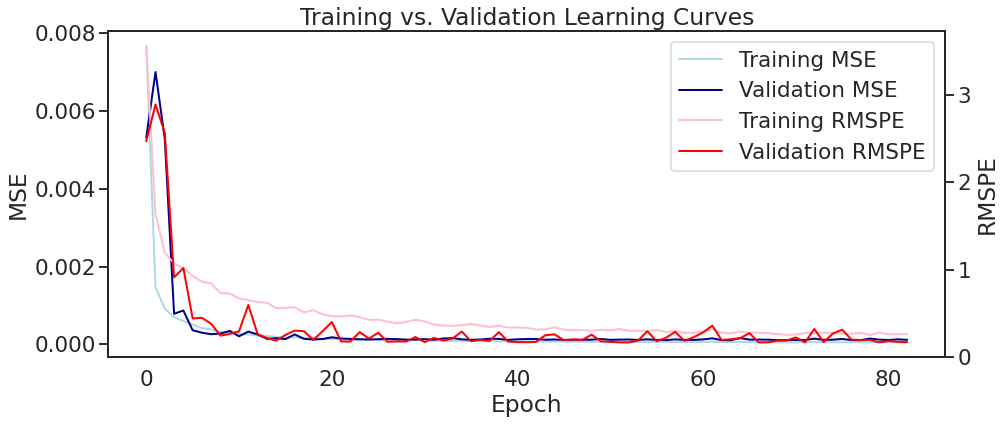

In [ ]:
# VISUALIZING LEARNING CURVES
viz_train_val_metrics(lstm_8_res)

In [ ]:
# FORECASTING ON VALIDATION SET
lstm_8_preds = forecast_multi(lstm_8, val_idx)

# SCALING OUTPUT TO MINMAXSCALER FITTED TO TRAINING CURRENT VOLUME
lstm_8_preds_scaled = scale(scaler_vol, lstm_8_preds)

12/12 [==============================] - 2s 10ms/step


In [ ]:
# PLOTTING PREDICTIONS VS. TARGET VALUES ON VALIDATION SET
viz_model(y_val_scaled, lstm_8_preds_scaled, 
          f"Multivariate 2 Bidirect LSTM layers (32/16 units), {n_past} days look back, tanh activation")
plt.savefig(os.path.join(directory_to_img, 'lstm_8_preds.png'), 
            dpi=300, bbox_inches='tight')
plt.show();

NameError: ignored

In [ ]:
# APPEND METRICS OUTPUTS TO perf_df DATAFRAME
log_perf(y_val_scaled, lstm_8_preds_scaled, 
         f"Multivariate 2 Bidirect LSTM layers (32/16 units), n_past={n_past}, batch={batch_size}, tanh")

## **Final Model**

In [ ]:
perf_df.sort_values(by='Validation RMSPE', ascending=True)

For this final model, I'll re-create the same architecture as model #12 (Multivariate Bidirectional LSTM with 2 layers of 32/16 units) and a lookback window `n_past = 30` and `batch_size = 64`. However, I'll extend the training to include the validation set as well. This is important in time series data since the more recent time steps would most likely carry more relevant information for successful forecasting than data from a year ago.

Since the validation MSE and RMSPE lines have been very unstable, I will extend the training epochs to 500 to seee if that could help capture better weights.

In [ ]:
# CREATE DATASET THAT COMBINES BOTH TRAINING & VALIDATION
tv_df = input_df[:split_time_2]
tv_y = df.vol_future[:split_time_2]

In [ ]:
tf.keras.backend.clear_session()

# SET SEED FOR REPRODUCIBILITY
np.random.seed(seed)

n_past = 30
batch_size = 64
n_dims = input_df.shape[1]

mat_X_tv, mat_y_tv = windowed_dataset(tv_df, tv_y, n_past)

# CONSTRUCTING MULTIVARIATE BIDIRECTIONAL LSTM NN
lstm_final = tf.keras.models.Sequential([  
    tf.keras.layers.InputLayer(input_shape=[n_past, n_dims]),   
    # BATCH NORMALIZATION  
    tf.keras.layers.BatchNormalization(), 

    # ADDING 1st LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Dropout(0.1),
    
    # ADDING 2nd LSTM LAYER
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dropout(0.1),

    # DENSE OUTPUT LAYER
    tf.keras.layers.Dense(1)
])

lstm_final.compile(loss='mse', 
                    optimizer="adam", 
                    metrics=[rmspe])

checkpoint_cb = ModelCheckpoint('lstm_final.h5',
                                save_best_only=True,
                                monitor='val_rmspe')

# STOPPING THE TRAINING IF VALIDATION RMSPE IS NOT IMPROVING 
early_stopping_cb = EarlyStopping(patience=30,
                                  restore_best_weights=True,
                                  monitor='val_rmspe')

print(lstm_final.summary())

In [ ]:
lstm_final_res = lstm_final.fit(mat_X_tv, mat_y_tv, epochs=500,
                                validation_split=0.2,
                                callbacks=[checkpoint_cb, early_stopping_cb],
                                verbose=0, batch_size=batch_size, shuffle=True)

In [ ]:
viz_train_val_metrics(lstm_final_res)

### Final Model's Predictions on Test Set

In [ ]:
# FORECASTING ON VALIDATION SET
y_test_preds = forecast_multi(lstm_final, test_idx)

In [ ]:
y_test_preds.describe()

In [ ]:
y_test.describe()

In [ ]:
# GETTING DAILY VOLATILITY QUANTILES
q1 = df.vol_current[:split_time_2].describe()['25%']

q2 = df.vol_current[:split_time_2].describe()['50%']

q3 = df.vol_current[:split_time_2].describe()['75%']

In [ ]:
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib

# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Test Set Target Volatility")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls=':',
                label=f"Current Daily Volatility")
    ax1.plot(y_test_preds, color='orange', lw=3,
                label=f'Test Set Forecasted Volatility')
    
    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q, color=q_colors[i], alpha=0.5, label=f'Daily Volatility Q{i+1}', ls='-.', lw=1,
                    xmin=df.vol_future[-n_display:].index[0],
                    xmax=df.vol_future[-n_display:].index[-1])
        
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Prediction on Test Set \n(Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_test_preds.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

In [ ]:
# GENERATING PREDICTIONS ON THE WHOLE DATASET (7 years)
mat_X_all, _ = windowed_dataset(input_df, df.vol_future, n_past)
preds_all = pd.Series(lstm_final.predict(mat_X_all)[:,0], 
                      index=df.index[-(mat_X_all).shape[0]:])

In [ ]:
# Ref: https://stackoverflow.com/questions/31162780/how-to-plot-a-rectangle-on-a-datetime-axis-using-matplotlib
# PLOTTING MODEL PREDICTIONS VS. TARGET VALUES
with sns.axes_style("white"):
    fig, ax1 = plt.subplots(figsize=(18,7))
    # ZOOMING IN THE LAST n_display VALUES
    n_display = 365

    ax1.plot(df.vol_future[-n_display:], color='blue', 
                label=f"Next {n_future} days' Daily Volatility (Target)")
    ax1.plot(df.vol_current[-n_display:], color='gray',  ls='--',
                label=f"Current Daily Volatility")
    ax1.plot(preds_all[-n_display:], color='orange', lw=3,
                label=f'Forecasted Volatility')

    q_colors = ['gray', 'black', 'gray']
    for i, q in enumerate([q1, q2, q3]):
        ax1.hlines(y=q,
                   xmin=df.vol_future[-n_display:].index[0],
                   xmax=df.vol_future[-n_display:].index[-1],
                   label=f'Daily Volatility Q{i+1}',
                   ls='-.', lw=1, color=q_colors[i], alpha=0.5)
    
    # ADD RECTANGLE TO PLOT AS BACKGROUND FOR TEST DATA    
    w = len(test_idx) - 1 
    h = df.vol_future[-n_display:].max() - df.vol_future[-n_display:].min()
    x0 = mdates.date2num(df.index[split_time_2])
    y0 = df.vol_future[-n_display:].min()
    rect = Rectangle((x0, y0), w, h, color ='green', alpha=0.1)
    ax1.add_patch(rect)

    # ADD TEXT
    ax1.text(df.index[(split_time_2 + 3)], 0.05, 
             'Test Data\n(30 days)', 
             fontsize=15, color='black')

    plt.title(f'Final Model Predictions (Zooming in the Most Recent {n_display} Days)', fontsize=20)
    ax1.legend(loc='upper left', prop={'size': 14})
    plt.tight_layout()
    plt.savefig(os.path.join(directory_to_img, 'final_lstm_preds.png'), 
                dpi=300, bbox_inches='tight')
    plt.show();

It should be stressed that the model was trained on both the training and validation data this time. Therefore it'd naturally trace the target more closely up until the third week of July 2021 where the validation ends. 

In [ ]:
perf_df.to_pickle("performance_df.pkl")

In [ ]:
print('RMSPE on Test Set:', RMSPE(y_test, y_test_preds))

In [ ]:
1-RMSPE(y_test, y_test_preds)

# **Вывод**

Что касается результативности на валидационной выборке (23.07.2020 — 25.07.2021), моя последняя модель LSTM имеет RMSPE 0,161, что примерно на 4,42% лучше, чем у наиболее эффективного варианта найденных моделей GARCH — TARCH. (1,2) с RMSPE 0,200954. Поскольку GARCH по-прежнему остается самой популярной моделью прогнозирования волатильности, многомерный LSTM потенциально может дать инвесторам преимущество с точки зрения более высокой точности прогнозирования.

# Литература:

1. Géron, A. (2019). *In Hands-on machine learning with Scikit-Learn & TensorFlow: concepts, tools, and techniques to build intelligent systems.* O'Reilly Media, Inc.

2. Sinclair, E. (2020). *Positional option trading: An advanced guide.* John Wiley &amp; Sons. 

3. https://algotrading101.com/learn/yfinance-guide/ 

4. https://www.coursera.org/learn/tensorflow-sequences-time-series-and-prediction/supplement/DM4fi/convolutional-neural-networks-course

5. https://insights.deribit.com/options-course/